In [1]:
## imports

import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime

# import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors

%load_ext autoreload
%autoreload 2

In [2]:
from defs import Nino34_timeseries, Confidence_intervals, MT_spectrum, FFT_spectrum, trim_axs, find_nearest, MonthConverter

In [3]:
figwidth1 = 8.3;
figwidth2 = 12;
labelfontsize = 13;
legendfontsize = 12;
titlefontsize = 13;

## Load observations

In [117]:
## HadISST data
## https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html
## 1870 - 2020 SST data

file = 'observations/HadISST/HadISST_sst.nc'
ds   = xr.open_dataset(file)

minlat = -5;  maxlat = 5;
minlon = -170; maxlon = -120;
var    = ds.sst; lat = ds.latitude; lon = ds.longitude; 
dimlat = 'latitude'; dimlon = 'longitude'

## calculate nino3.4
Nino34       = var.where(lat>minlat).where(lat<maxlat).where(lon>minlon).where(lon<maxlon).mean(dim=dimlat).mean(dim=dimlon)

# last 100y
Nino34 = Nino34[-1200:]

## take off climatology
nino_hadisst = Nino34.groupby('time.month') - Nino34.groupby('time.month').mean(dim='time')

## last 100y
# nino_hadisst = nino_hadisst[-1200:]

## linear detrending (to remove 'climate change' trends)
t = range(len(nino_hadisst))
p = np.polyfit(t, nino_hadisst, 1)
l = t*p[0] + p[1]
nino_hadisst = nino_hadisst - l

## 30y running mean er af halen?

mtfreq_obs, mtspec_obs = MT_spectrum(nino_hadisst.values, True, True)
mt_ci90_obs, mt_ci95_obs, mt_ci99_obs = Confidence_intervals(nino_hadisst.values, True, True, "linear", 'MT', 10000)

## Load modellist

In [4]:
## quick check model

modellist = ['CCSM4', 'CCSM4-UoT', 'CCSM4-Utr', 'CESM1.2', 'CESM2', 'COSMOS', 'EC-Earth3.3',
             'GISS2.1G', 'HadCM3', 'HadGEM3', 'IPSLCM5A', 'IPSLCM5A2', 'IPSLCM6A', 'MIROC4m', 
             'MRI2.3', 'NorESM-L', 'NorESM1-F']

i=2
model=modellist[i]
print('model = ' + model)

run = 'EOI400'
file = 'models/' + model + '/' + model + '_' + run + '.SST.timeseries_no_ann_cycle.nc'
ds = xr.open_dataset(file)
ds

model = CCSM4-Utr


<xarray.Dataset>
Dimensions:    (latitude: 180, longitude: 360, time: 1200)
Coordinates:
  * time       (time) datetime64[ns] 1901-01-14 1901-02-14 ... 2000-12-14
  * latitude   (latitude) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    month      (time) int32 ...
    year       (time) int32 ...
Data variables:
    tos        (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.5

# Defines

In [82]:
def integral_power(Tmin, Tmax, power):

    ## Calculate the integral of the power spectrum for period range Tmin to Tmax (periods in years)
    
    fmax = 1./(12*Tmin); fmin = 1./(12*Tmax);

    imax = find_nearest(freq, fmax, index=True, nearest=False)
    imin = find_nearest(freq, fmin, index=True, nearest=False)

    integral = np.trapz(power[imin:imax], x=freq[imin:imax])
    
    return integral

# Calculate the power spectra & confidence levels

### Nino3.4 index

In [5]:
## Calculate Nino34 index time series 

trend_type = "linear"

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
    
    ds = Nino34_timeseries(model = modellist[i], run='E280', trend = trend_type)
    if i==0: 
        nino_e280   = np.zeros((len(ds), len(modellist)))    
        nino_eoi400 = np.zeros((len(ds), len(modellist))) 
        
    nino_e280[:,i]   = ds
    nino_eoi400[:,i] = Nino34_timeseries(model = modellist[i], run='EOI400', trend = trend_type)


model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = CESM1.2
model = CESM2
model = COSMOS


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = EC-Earth3.3


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy

model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A


/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/xarray/coding/times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/pliomip/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


### MT / Fourier spectra

In [6]:
## Calculate power spectrum using FFT & MT spectral methods from Nino3.4 index

norm = True; scale = True; trend = "linear";

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
   
    ## FFT spectrum
#     freq, spec = FFT_spectrum(nino_e280[:,i], norm, scale, trend)
#     if i==0: 
#         fftspec_e280   = np.zeros((len(spec), len(modellist)))    
#         fftspec_eoi400 = np.zeros((len(spec), len(modellist))) 
#         fftfreq_e280   = freq
#         fftfreq_eoi400   = freq
        
#     fftspec_e280[:,i]   = spec
#     _, fftspec_eoi400[:,i] = FFT_spectrum(nino_eoi400[:,i], norm, scale, trend)

    ## MT spectrum
    freq, spec = MT_spectrum(nino_e280[:,i], norm, scale, trend)
    if i==0: 
        mtspec_e280   = np.zeros((len(spec), len(modellist)))    
        mtspec_eoi400 = np.zeros((len(spec), len(modellist))) 
        mtfreq_e280   = freq
        mtfreq_eoi400   = freq
        
    mtspec_e280[:,i]   = spec
    _, mtspec_eoi400[:,i] = MT_spectrum(nino_eoi400[:,i], norm, scale, trend)


model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr
model = CESM1.2
model = CESM2
model = COSMOS
model = EC-Earth3.3
model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A
model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


### Confidence intervals

In [8]:
## Calculate confidence intervals using MT spectral methods from Nino3.4 index

norm = True; scale = True; trend = "linear"; Nsur = 10000;

mt_ci90_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci95_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci99_e280   = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci90_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci95_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))
mt_ci99_eoi400 = np.zeros((len(mtfreq_e280), len(modellist)))

for i in range(0, len(modellist)):
    
    print('model = ' + modellist[i])
   
    mt_ci90_e280[:,i], mt_ci95_e280[:,i], mt_ci99_e280[:,i] = Confidence_intervals(nino_e280[:,i], 
                                                                                   norm, scale, trend, 'MT', Nsur)
    mt_ci90_eoi400[:,i], mt_ci95_eoi400[:,i], mt_ci99_eoi400[:,i] = Confidence_intervals(nino_eoi400[:,i], 
                                                                                         norm, scale, trend, 'MT', Nsur)


model = CCSM4
model = CCSM4-UoT
model = CCSM4-Utr
model = CESM1.2
model = CESM2
model = COSMOS
model = EC-Earth3.3
model = GISS2.1G
model = HadCM3
model = HadGEM3
model = IPSLCM5A
model = IPSLCM5A2
model = IPSLCM6A
model = MIROC4m
model = MRI2.3
model = NorESM-L
model = NorESM1-F


## Plot spectra


# **Appendix Figure 2**

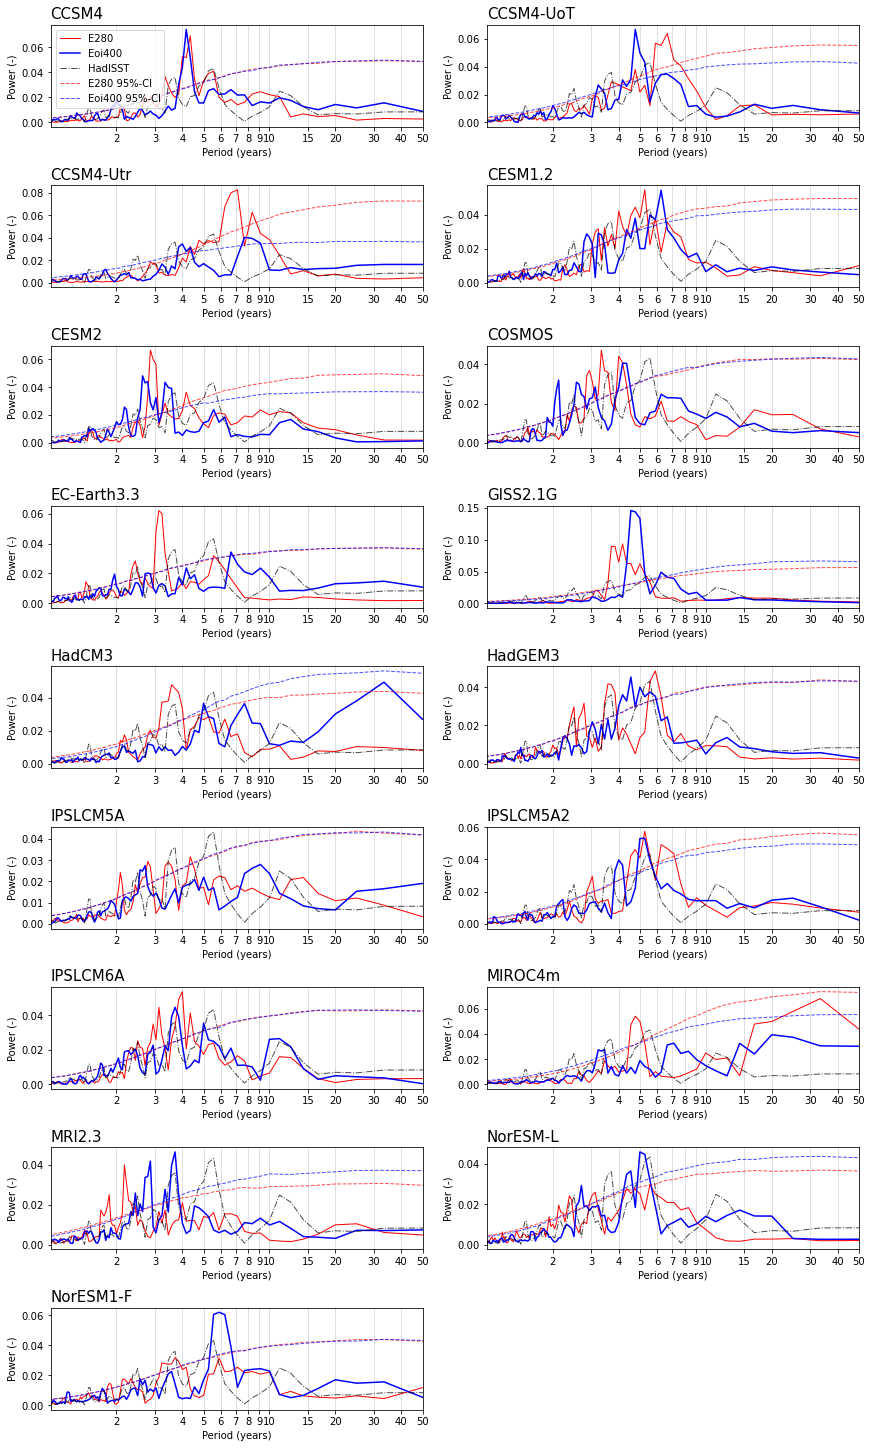

In [112]:
# 1 - 10 yaar

fig1, axs = plt.subplots(nrows=9, ncols=2, figsize=(figwidth2, 20), constrained_layout=True)
axs = trim_axs(axs, len(modellist))

conf = True

for ax1, i in zip(axs, range(0,len(modellist))):

#     ax1.plot(fftfreq_e280, fftspec_e280[:,i], '--r', linewidth = 1, alpha = 0.5, label='E280 FFT')
    ax1.plot(1/(12*mtfreq_e280), mtspec_e280[:,i], '-r', linewidth = 1, label = 'E280')
#     ax1.plot(fftfreq_eoi400, fftspec_eoi400[:,i], '--b', linewidth = 1.5, alpha=0.5, label='EOI400 FFT')
    ax1.plot(1/(12*mtfreq_eoi400), mtspec_eoi400[:,i], '-b', linewidth = 1.5, label = 'Eoi400')
    
    ax1.plot(1/(12*mtfreq_obs), mtspec_obs, 'k-.', linewidth = 1, alpha = 0.7, label = 'HadISST')
    
    if conf == True:
        ax1.plot(1/(12*mtfreq_e280), mt_ci95_e280[:,i], 'r--', alpha=0.7, linewidth = 1, label= 'E280 95%-CI')
        ax1.plot(1/(12*mtfreq_eoi400), mt_ci95_eoi400[:,i], 'b--', alpha=0.7, linewidth = 1, label='Eoi400 95%-CI')
    
    if i==0:
        ax1.legend(loc='upper left')

    ax1.set_xscale('log')
    
    ax1.set_xlim([1,50])
    ticks = [2,3,4,5,6,7,8,9,10,15,20,30,40,50]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(ticks)
    ax1.set_xlabel('Period (years)')
    ax1.xaxis.grid(alpha=0.5)
    ax1.get_xaxis().set_tick_params(which='minor', size=0)
    ax1.get_xaxis().set_tick_params(which='minor', width=0)
    
#     ax1.set_xticks([1e-2]); ax1.set_xticklabels([1e-2])
    # ax1.set_ylim(0, 150000) 
    ax1.set_ylabel('Power (-)');
    ax1.set_title(modellist[i], loc='left', fontsize=15)

# plt.savefig('figures/Nino34_powerspectra_MT_obs_v2.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/appendixfigure2_v2.pdf', bbox_inches='tight')

# **Figure 3**

NameError: name 'mtfreq_obs' is not defined

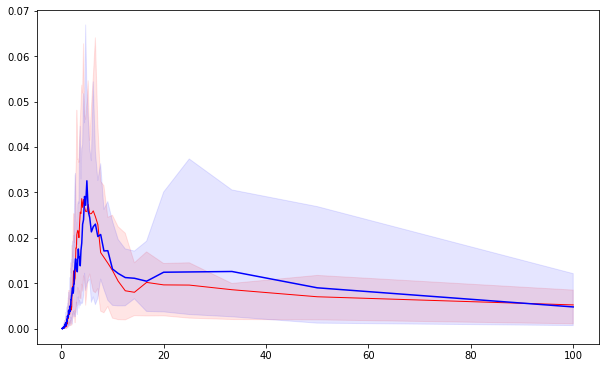

In [10]:
mean_mtspec_e280    = np.mean(mtspec_e280, axis=1)
mean_mtspec_eoi400  = np.mean(mtspec_eoi400, axis=1)
median_mtspec_e280    = np.median(mtspec_e280, axis=1)
median_mtspec_eoi400  = np.median(mtspec_eoi400, axis=1)

x = 1/(12*mtfreq_e280)

## possible to include a range of modelled values around the mean
fill = True;
d=1

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(figwidth1, 5), constrained_layout=True)

ym = np.mean(mtspec_e280, axis=1)
ys = np.std(mtspec_e280, axis=1)
ax1.plot(x, ym, 'r-', linewidth =1, label = 'E280 Ensemble mean')

y=np.sort(mtspec_e280, axis=1)
if fill == True:
    ax1.fill_between(x, y[:,d], y[:,(-d-1)], color='r', alpha=0.1, hatch='')
#     ax1.fill_between(x, (ym-ys), (ym+ys), color='r', alpha=0.1)

ym = np.mean(mtspec_eoi400, axis=1)
ys = np.std(mtspec_eoi400, axis=1)
ax1.plot(x, ym, 'b-', linewidth = 1.5, label = 'Eoi400 Ensemble mean')

y=np.sort(mtspec_eoi400, axis=1)
if fill == True:
    ax1.fill_between(x, y[:,d], y[:,(-d-1)], color='b', alpha=0.1, hatch='')
#     ax1.fill_between(x, (ym-ys), (ym+ys), color='b', alpha=0.1)

ax1.plot(1/(12*mtfreq_obs), mtspec_obs, 'k-.', linewidth = 1.0, alpha = 1, label = 'HadISST 1920-2020')

ax1.legend(fontsize=legendfontsize, loc='upper left', shadow=True)

ax1.set_xscale('log')
    
ax1.set_xlim([1, 50])
ticks = [2,3,4,5,6,7,8,9,10, 15,20,30,40,50]
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks)
ax1.set_xlabel('Period (years)', fontsize=labelfontsize)
ax1.xaxis.grid(alpha=0.5)
ax1.get_xaxis().set_tick_params(which='minor', size=0)
ax1.get_xaxis().set_tick_params(which='minor', width=0)
ax1.set_ylim([0, 0.07])


ax1.set_ylabel('Power (-)', fontsize=labelfontsize);

# plt.savefig('figures/median_power_spectra.eps', bbox_inches='tight', dpi=200)
# plt.savefig('figures/mean_power_spectra.pdf', bbox_inches='tight')
# plt.savefig('figures/figure3.pdf', bbox_inches='tight')


## Power integral procedure

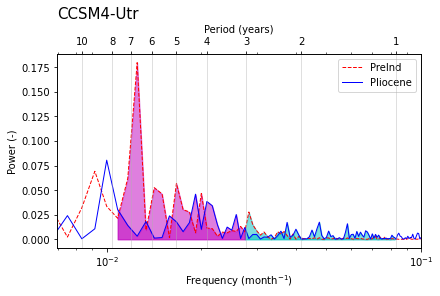

In [353]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6,4), constrained_layout=True)

ax1.set_xlim([1.0/(12.0 * 12), 1.0/(1 * 10.0)])
ax1.set_xlabel('Frequency (month$^{-1}$)')
ax2 = ax1.twiny()

new_tick_locations = 1. / (12 * np.array([10,8,7,6,5,4,3,2,1]))
ax2.set_xlabel('Period (years)')
ax2.set_xscale('log')

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(MonthConverter(new_tick_locations))
ax2.grid(alpha=0.5)

i=2
ax1.plot(freq, power_PI[:,i], '--r', linewidth = 1, label='PreInd')
ax1.fill_between(freq[33:100], power_PI[33:100,i], color='c', alpha=0.5)
ax1.fill_between(freq[13:34], power_PI[13:34,i], color='m', alpha=0.5)

ax1.plot(freq, power_Plio[:,i], '-b', linewidth = 1, label='Pliocene')
ax1.fill_between(freq[33:100], power_Plio[33:100,i], color='c', alpha=0.5)
ax1.fill_between(freq[13:34], power_Plio[13:34,i], color='m', alpha=0.5)

ax1.legend()

ax1.set_xscale('log')
# ax1.set_ylim(0, 0.125) 
ax1.set_ylabel('Power (-)');
ax1.set_title(modellist[i], loc='left', fontsize=15)

# plt.savefig('figures/Utrecht_spectrum_integrals.png', bbox_inches='tight', dpi=100)

In [242]:
highf_Tmin = 1; highf_Tmax = 3;
lowf_Tmin = 3; lowf_Tmax = 8;

lowfreq_PI    = np.zeros(len(modellist))
lowfreq_Plio  = np.zeros(len(modellist)) 
highfreq_PI   = np.zeros(len(modellist))
highfreq_Plio = np.zeros(len(modellist))

for i in range(len(modellist)):
    lowfreq_PI[i]    = integral_power(lowf_Tmin,  lowf_Tmax,  power_PI[:,i])
    lowfreq_Plio[i]  = integral_power(lowf_Tmin,  lowf_Tmax,  power_Plio[:,i])
    highfreq_PI[i]   = integral_power(highf_Tmin, highf_Tmax, power_PI[:,i])
    highfreq_Plio[i] = integral_power(highf_Tmin, highf_Tmax, power_Plio[:,i])


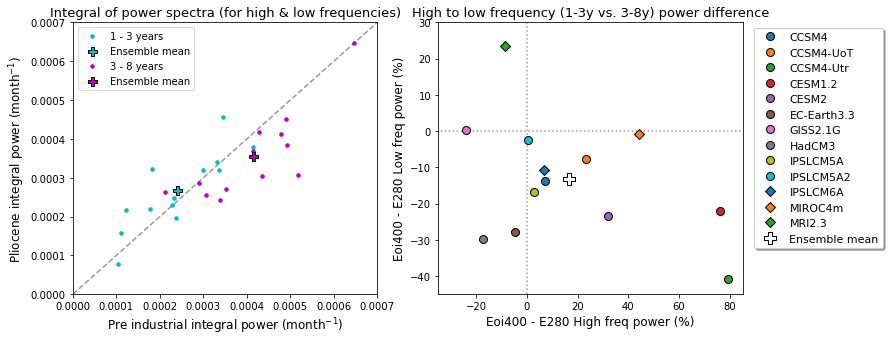

In [373]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

p = 0;
axmin = 0; axmax = 0.0007;

MM_high_PI = np.mean(highfreq_PI); MM_high_Plio = np.mean(highfreq_Plio);
MM_low_PI = np.mean(lowfreq_PI); MM_low_Plio = np.mean(lowfreq_Plio);

ax[p].plot(highfreq_PI, highfreq_Plio, 'c.', label='1 - 3 years', markersize = 7)
ax[p].plot(MM_high_PI, MM_high_Plio, 'P', label='Ensemble mean', markerfacecolor='c', markeredgecolor='k',markersize=9)

ax[p].plot(lowfreq_PI, lowfreq_Plio, 'm.', label='3 - 8 years', markersize = 7)
ax[p].plot(MM_low_PI, MM_low_Plio, 'P', label='Ensemble mean', markerfacecolor='m', markeredgecolor='k',markersize=9)

ax[p].plot([axmin, axmax], [axmin, axmax], 'k--', alpha =0.4, zorder=-1)

ax[p].set_xlim([axmin, axmax]); ax[p].set_ylim([axmin, axmax])
ax[p].legend()
ax[p].set_xlabel('Pre industrial integral power (month$^{-1}$)', fontsize=12)
ax[p].set_ylabel('Pliocene integral power (month$^{-1}$)', fontsize=12)
ax[p].set_title('Integral of power spectra (for high & low frequencies)', fontsize=13)

p = 1;
# axmin = 0; axmax = 2.;
axmin = -45; axmax = 85;

x = 100*(highfreq_Plio - highfreq_PI)/highfreq_PI #highfreq_PI/lowfreq_PI
y = 100*(lowfreq_Plio - lowfreq_PI)/lowfreq_PI #highfreq_Plio/lowfreq_Plio

for i in range(len(modellist)):
    if i<10: ax[p].plot(x[i], y[i], 'o', label = modellist[i], markersize = 8, markeredgecolor = 'k');
    else:    ax[p].plot(x[i], y[i], 'D', label = modellist[i], markersize = 7, markeredgecolor = 'k');

# ax[p].plot(highfreq_PI/lowfreq_PI, highfreq_Plio/lowfreq_Plio, 'y.', label='1 - 3 y / 3 - 8 y')
ax[p].plot(np.mean(x), np.mean(y), 'P', label='Ensemble mean', markerfacecolor='w', markeredgecolor='k',markersize=12)

# ax[p].plot([axmin, axmax], [axmin, axmax], 'k--', alpha=0.4, zorder=-1)
ax[p].plot([axmin, axmax], [0,0], 'k:', alpha=0.4, zorder=-1)
ax[p].plot([0,0], [axmin, axmax], 'k:', alpha=0.4, zorder=-1)

chartBox = ax[p].get_position()
ax[p].set_position([chartBox.x0, chartBox.y0, chartBox.width*1, chartBox.height])
ax[p].legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1, fontsize=11)

ax[p].set_xlim([-35, axmax]); ax[p].set_ylim([axmin, 30])
# ax[p].set_xlabel('Pre industrial integral power ratio (-)', fontsize=12)
# ax[p].set_ylabel('Pliocene integral power ratio (-)', fontsize=12)
ax[p].set_xlabel('Eoi400 - E280 High freq power (%)', fontsize=12)
ax[p].set_ylabel('Eoi400 - E280 Low freq power (%)', fontsize=12)
ax[p].set_title('High to low frequency (1-3y vs. 3-8y) power difference', fontsize=13)

# plt.savefig('figures/power_spectral_integrals_v2.png', bbox_inches='tight', dpi=100)

Text(0, 0.5, 'Pliocene integral power')

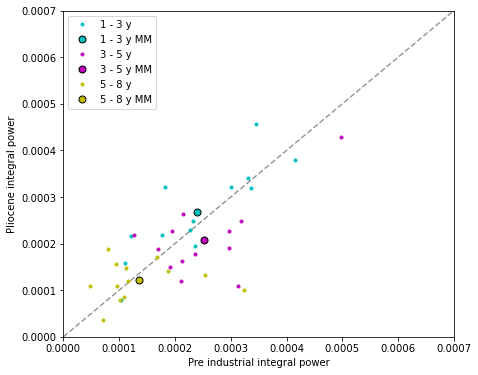

In [372]:
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(7,6))

axmin = 0; axmax = 0.0007;

Tmin_list = [1,3,5]
Tmax_list = [3,5,8]
colors = ['c','m','y']

for j in range(len(Tmin_list)):

    Tmin = Tmin_list[j]; 
    Tmax = Tmax_list[j];
    freq_PI    = np.zeros(len(modellist)); freq_Plio  = np.zeros(len(modellist));
    for i in range(len(modellist)):
        freq_PI[i]    = integral_power(Tmin,  Tmax,  power_PI[:,i])
        freq_Plio[i]  = integral_power(Tmin,  Tmax,  power_Plio[:,i])

    ax.plot(freq_PI, freq_Plio, '.', color=colors[j], label=str(Tmin)+' - '+str(Tmax)+' y')
    ax.plot(np.mean(freq_PI), np.mean(freq_Plio), 'o', label=str(Tmin)+' - '+str(Tmax)+' y'+' MM', markerfacecolor=colors[j], markeredgecolor='k',markersize=7)

ax.plot([axmin, axmax], [axmin, axmax], 'k--', alpha =0.4, zorder=-1)

ax.set_xlim([axmin, axmax]); ax.set_ylim([axmin, axmax])
ax.legend()
ax.set_xlabel('Pre industrial integral power')
ax.set_ylabel('Pliocene integral power')

## Count significant peaks procedure

In [126]:
# period = np.empty(len(freq))

# i = 2
peaks_90_e280 = np.array([0.]);   peaks_95_e280 = np.array([0.]);   peaks_99_e280 = np.array([0.]);
peaks_90_eoi400 = np.array([0.]); peaks_95_eoi400 = np.array([0.]); peaks_99_eoi400 = np.array([0.]);

for i in range(len(modellist)):
    for j in range(1,len(mtfreq_e280)):
        period = 1.0 / mtfreq_e280[j] / 12.0;

        if mtspec_e280[j,i] > mt_ci90_e280[j,i]:
            peaks_90_e280 = np.concatenate((peaks_90_e280, np.array([period])),axis=0)
        if mtspec_e280[j,i] > mt_ci95_e280[j,i]:
            peaks_95_e280 = np.concatenate((peaks_95_e280, np.array([period])),axis=0)
        if mtspec_e280[j,i] > mt_ci99_e280[j,i]:
            peaks_99_e280 = np.concatenate((peaks_99_e280, np.array([period])),axis=0)
            
        if mtspec_eoi400[j,i] > mt_ci90_eoi400[j,i]:
            peaks_90_eoi400 = np.concatenate((peaks_90_eoi400, np.array([period])),axis=0)
        if mtspec_eoi400[j,i] > mt_ci95_eoi400[j,i]:
            peaks_95_eoi400 = np.concatenate((peaks_95_eoi400, np.array([period])),axis=0)
        if mtspec_eoi400[j,i] > mt_ci99_eoi400[j,i]:
            peaks_99_eoi400 = np.concatenate((peaks_99_eoi400, np.array([period])),axis=0)
        
peaks_90_e280 = peaks_90_e280[1:];     peaks_95_e280 = peaks_95_e280[1:];     peaks_99_e280 = peaks_99_e280[1:];
peaks_90_eoi400 = peaks_90_eoi400[1:]; peaks_95_eoi400 = peaks_95_eoi400[1:]; peaks_99_eoi400 = peaks_99_eoi400[1:]

#observations:
peaks_90_obs = np.array([0.]);   peaks_95_obs = np.array([0.]);   peaks_99_obs = np.array([0.]);
for j in range(1,len(mtfreq_obs)):
        period = 1.0 / mtfreq_obs[j] / 12.0;

        if mtspec_obs[j] > mt_ci90_obs[j]:
            peaks_90_obs = np.concatenate((peaks_90_obs, np.array([period])),axis=0)
        if mtspec_obs[j] > mt_ci95_obs[j]:
            peaks_95_obs = np.concatenate((peaks_95_obs, np.array([period])),axis=0)
        if mtspec_obs[j] > mt_ci99_obs[j]:
            peaks_99_obs = np.concatenate((peaks_99_obs, np.array([period])),axis=0)

peaks_90_obs = peaks_90_obs[1:];     peaks_95_obs = peaks_95_obs[1:];     peaks_99_obs = peaks_99_obs[1:];
           
            
print("Peak counting procedure finished")

Peak counting procedure finished


# **Figure 4**

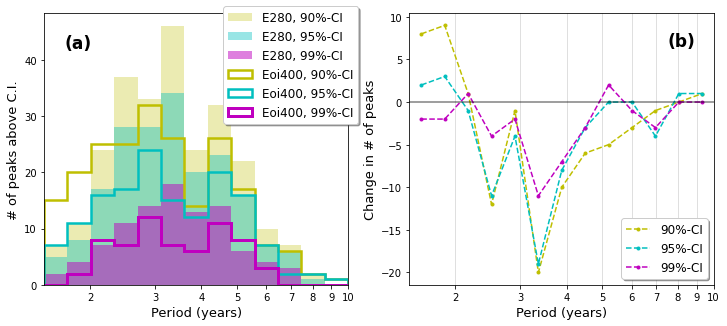

In [74]:
caption = True;

fig, axs = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

binlist = np.logspace(np.log10(1.5), np.log10(10), 14)
ticklocs = [2,3,4,5,6,7,8,9,10]

ax=axs[0]

ax.hist(peaks_90_e280,   bins=binlist, color='y', histtype = 'stepfilled', alpha=0.3, label = 'E280, 90%-CI')
ax.hist(peaks_95_e280,   bins=binlist, color='c', histtype = 'stepfilled', alpha=0.4, label = 'E280, 95%-CI')
ax.hist(peaks_99_e280,   bins=binlist, color='m', histtype = 'stepfilled', alpha=0.5, label = 'E280, 99%-CI')
ax.hist(peaks_90_eoi400, bins=binlist, color='y', histtype = 'step', alpha=1, linewidth=2.5, linestyle='-', label = 'Eoi400, 90%-CI')
ax.hist(peaks_95_eoi400, bins=binlist, color='c', histtype = 'step', alpha=1, linewidth=2.5, linestyle='-', label = 'Eoi400, 95%-CI')
ax.hist(peaks_99_eoi400, bins=binlist, color='m', histtype = 'step', alpha=1, linewidth=3, linestyle='-', label = 'Eoi400, 99%-CI')

ax.legend(fontsize=legendfontsize, bbox_to_anchor=(0.57, 0.57),shadow=True)
ax.set_ylabel('# of peaks above C.I.',fontsize=labelfontsize); 
ax.set_xlabel('Period (years)',fontsize=labelfontsize);
ax.set_xscale("log"); ax.set_xticks(ticklocs); ax.set_xticklabels(ticklocs); ax.set_xlim([1.5,10])
# ax.xaxis.grid(alpha=0.5, zorder=-1)

if caption == True:
    ax.text(1.7, 42, '(a)', fontsize = 17, fontweight = 'bold')

ax=axs[1]

bincenters = np.array([0.])
for i in range(len(binlist)-1):
    center = (binlist[i] + binlist[i+1])/2.
    bincenters = np.concatenate((bincenters, np.array([center])),axis=0)
bincenters = bincenters[1:]

peaknrs = np.zeros((3,2))

hist1, _ = np.histogram(peaks_90_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_90_eoi400, bins=binlist)
diff_90 = hist2 - hist1
peaknrs[0,0] = np.sum(hist1); peaknrs[0,1] = np.sum(hist2)

hist1, _ = np.histogram(peaks_95_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_95_eoi400, bins=binlist)
diff_95 = hist2 - hist1
peaknrs[1,0] = np.sum(hist1); peaknrs[1,1] = np.sum(hist2)

hist1, _ = np.histogram(peaks_99_e280,   bins=binlist)
hist2, _ = np.histogram(peaks_99_eoi400, bins=binlist)
diff_99 = hist2 - hist1
peaknrs[2,0] = np.sum(hist1); peaknrs[2,1] = np.sum(hist2)

ax.plot(bincenters, diff_90, color='y', marker='.', linestyle = '--')
ax.plot(bincenters, diff_95, color='c', marker='.', linestyle = '--')
ax.plot(bincenters, diff_99, color='m', marker='.', linestyle = '--')

ax.set_ylabel('Change in # of peaks',fontsize=labelfontsize); 
ax.set_xlabel('Period (years)',fontsize=labelfontsize);
ax.set_xscale("log"); ax.set_xticks(ticklocs); ax.set_xticklabels(ticklocs); ax.set_xlim([1.5,10])
ax.xaxis.grid(alpha=0.5, zorder=-1)
plt.axhline(0, color='black', alpha = 0.5);
ax.legend(['90%-CI', '95%-CI', '99%-CI'], fontsize=legendfontsize, shadow=True, loc='lower right');

if caption == True:
    ax.text(7.5, 6.6, '(b)', fontsize = 17, fontweight = 'bold')

# plt.savefig('figures/confident_peaks_figure.png', bbox_inches='tight', dpi=200)
# plt.savefig('figures/confident_peaks_figure_v2.pdf', bbox_inches='tight')
# plt.savefig('figures/figure4.pdf', bbox_inches='tight')